**Простейший многослойный персептрон для решения задачи стажировки**

Было интересно поработать с простейшим многослойным персептроном и проверить, как оптимизаторы и функции активации повлияют на итоговую точность модели.

С помощью оптимизатора **Adam** была достигнута **точность 0,89**

In [1]:
# Импортируем библиотеки
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, AdamW, Adadelta, Adagrad, Adamax, Adafactor, Nadam, Ftrl
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import matplotlib.pyplot as plt
import gdown, os, random
import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder

In [2]:
# Запишем фатасет в переменную и выведем на экран
df = pd.read_csv('dataset.csv', quoting=csv.QUOTE_NONE)
display(df)

,id_ответа,Раса,Пол,Возраст,Статус курения,ECOG,Есть опухолевая нагрузка? (симптомная опухоль),Ко-мутации KRAS,Ко-мутации p53.,Ко-мутации STK11,...,PD-L1 статус,Предпочтение пациента по ответу на терапию,Ответ эксперта (Лактионов),"""Поставьте галочку","если уверены на 100%""",Если 75%,Если 50%,"""Альтернатива","если 50% - обязательно""",Комментарий
0,1.0,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,Не исследовался,Результативность лечения,Дурвалумаб,True,False,False,0,0,NaN,NaN
1,2.0,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,Не исследовался,Результативность лечения,Дурвалумаб,True,False,False,0,0,NaN,NaN
2,3.0,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,Не исследовался,Результативность лечения,Наблюдение,False,True,False,Дурвалумаб,Нет доказательной базы для назначения после пе...,NaN,NaN
3,4.0,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,Не исследовался,Результативность лечения,Дурвалумаб,False,True,False,0,Возможно есть мутации и эффективность Дурвалум...,NaN,NaN
4,5.0,Азиатская,Мужской,До 70,В настоящее время,0-1,да,да,да,да,...,Не исследовался,Результативность лечения,Дурвалумаб,False,True,False,0,Возможно есть мутации и эффективность Дурвалум...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10085,9726.0,Азиатская,Мужской,>70,Курение в прошлом (бросил более 1 месяца до 1...,0-1,нет,да,да,да,...,Не исследовался,Результативность лечения,Наблюдение,False,True,False,Дурвалумаб,Нет доказательной базы для назначения после пе...,NaN,NaN
10086,9727.0,Азиатская,Мужской,>70,Курение в прошлом (бросил более 1 месяца до 1...,0-1,нет,да,да,да,...,Не исследовался,Результативность лечения,Наблюдение,True,False,False,0,"""Возможна низкая эффективность Дурвалумаба","Осимертиниб без доказательной базы""",NaN
10087,9728.0,Азиатская,Мужской,>70,Курение в прошлом (бросил более 1 месяца до 1...,0-1,нет,да,да,да,...,Не исследовался,Результативность лечения,Наблюдение,True,False,False,0,"""Возможна низкая эффективность Дурвалумаба","Осимертиниб без доказательной базы""",NaN
10088,9729.0,Азиатская,Мужской,>70,Курение в прошлом (бросил более 1 месяца до 1...,0-1,нет,да,да,да,...,Не исследовался,Результативность лечения,Наблюдение,True,False,False,0,0,NaN,NaN


In [3]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder ко всем столбцам
for col in df.columns:
    if df[col].dtype == 'object':  # Проверка, что столбец имеет тип 'object'
        df[col] = label_encoder.fit_transform(df[col].astype(str))

In [4]:
# Отделим входные переменные
x = df[df.columns[2:15]]
x

,Пол,Возраст,Статус курения,ECOG,Есть опухолевая нагрузка? (симптомная опухоль),Ко-мутации KRAS,Ко-мутации p53.,Ко-мутации STK11,Ко-мутации KEAP1,Срок от окончания ХЛТ,Молекулярный статус (только для неплоскоклеточного рака),PD-L1 статус,Предпочтение пациента по ответу на терапию
0,1,1,0,0,0,0,0,0,0,3,5,2,0
1,1,1,0,0,0,0,0,0,0,4,5,2,0
2,1,1,0,0,0,0,0,0,0,1,5,2,0
3,1,1,0,0,0,0,0,0,0,3,4,2,0
4,1,1,0,0,0,0,0,0,0,4,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10085,1,0,2,0,1,0,0,0,0,1,4,2,0
10086,1,0,2,0,1,0,0,0,0,3,3,2,0
10087,1,0,2,0,1,0,0,0,0,4,3,2,0
10088,1,0,2,0,1,0,0,0,0,1,3,2,0


In [5]:
# Выходная переменная
y = df[df.columns[16:21]]
y

,"""Поставьте галочку","если уверены на 100%""",Если 75%,Если 50%,"""Альтернатива"
0,1,0,0,0,3
1,1,0,0,0,3
2,0,1,0,3,8
3,0,1,0,0,7
4,0,1,0,0,7
...,...,...,...,...,...
10085,0,1,0,3,8
10086,1,0,0,0,0
10087,1,0,0,0,0
10088,1,0,0,0,3


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=3)

print('Размеры сформированных массивов:')

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

Размеры сформированных массивов:
(8072, 13)
(2018, 13)
(8072, 5)
(2018, 5)


**Модель персептрона**

In [7]:
model = Sequential() # Последовательная модель нейронной сети

model.add(Dense(2040, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(800, activation='relu'))
model.add(Dense(5, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2040)              28560     
                                                                 
 dense_1 (Dense)             (None, 800)               1632800   
                                                                 
 dense_2 (Dense)             (None, 5)                 4005      
                                                                 
Total params: 1665365 (6.35 MB)
Trainable params: 1665365 (6.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Оптимизатор Adam - 0.8958**

Epoch 1/10
64/64 [==============================] - 6s 59ms/step - loss: 41.3836 - accuracy: 0.4128 - val_loss: 41.2132 - val_accuracy: 0.4227
Epoch 2/10
64/64 [==============================] - 3s 48ms/step - loss: 21.6528 - accuracy: 0.4948 - val_loss: 6.5415 - val_accuracy: 0.7483
Epoch 3/10
64/64 [==============================] - 4s 61ms/step - loss: 5.9895 - accuracy: 0.7610 - val_loss: 5.4561 - val_accuracy: 0.7859
Epoch 4/10
64/64 [==============================] - 5s 84ms/step - loss: 5.3494 - accuracy: 0.8081 - val_loss: 5.1896 - val_accuracy: 0.8246
Epoch 5/10
64/64 [==============================] - 3s 46ms/step - loss: 5.2651 - accuracy: 0.8252 - val_loss: 5.1184 - val_accuracy: 0.8380
Epoch 6/10
64/64 [==============================] - 3s 46ms/step - loss: 5.0987 - accuracy: 0.8393 - val_loss: 5.2100 - val_accuracy: 0.8226
Epoch 7/10
64/64 [==============================] - 3s 48ms/step - loss: 5.0687 - accuracy: 0.8481 - val_loss: 5.5432 - val_accuracy: 0.8196
Epoch 8/10

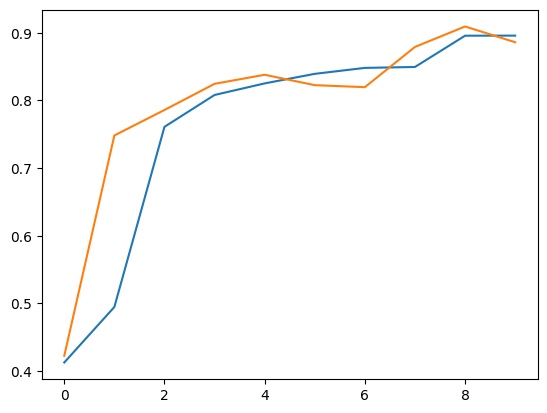

In [8]:
# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор RMSprop - 0.4607**

Epoch 1/10
111/111 [==============================] - 5s 39ms/step - loss: 61719.1641 - accuracy: 0.4504 - val_loss: 69352.0469 - val_accuracy: 0.4930
Epoch 2/10
111/111 [==============================] - 3s 28ms/step - loss: 81357.1562 - accuracy: 0.4585 - val_loss: 105183.3906 - val_accuracy: 0.4930
Epoch 3/10
111/111 [==============================] - 3s 30ms/step - loss: 96075.4062 - accuracy: 0.4546 - val_loss: 104144.3125 - val_accuracy: 0.4930
Epoch 4/10
111/111 [==============================] - 3s 26ms/step - loss: 101671.1562 - accuracy: 0.4539 - val_loss: 114285.9141 - val_accuracy: 0.4930
Epoch 5/10
111/111 [==============================] - 3s 27ms/step - loss: 94175.9766 - accuracy: 0.4588 - val_loss: 109383.2422 - val_accuracy: 0.4133
Epoch 6/10
111/111 [==============================] - 3s 29ms/step - loss: 76999.3438 - accuracy: 0.4501 - val_loss: 89780.7109 - val_accuracy: 0.4133
Epoch 7/10
111/111 [==============================] - 3s 29ms/step - loss: 70326.5938 - a

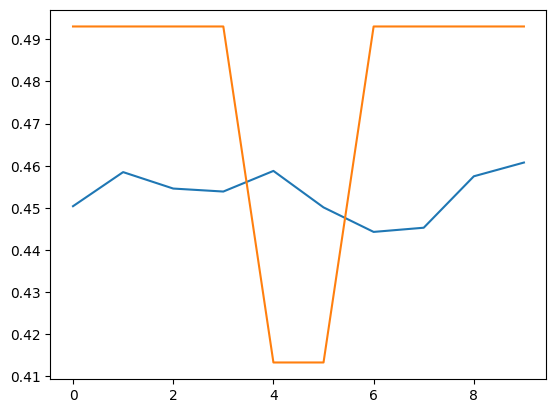

In [ ]:
# Компиляция модели
model.compile(optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор SGD - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 30ms/step - loss: nan - accuracy: 0.1151 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 24ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 3s 24ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 3s 24ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 27ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 25ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 3s 24ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

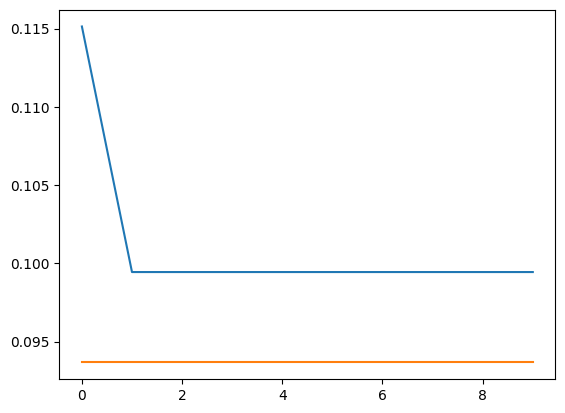

In [ ]:
# Компиляция модели
model.compile(optimizer=SGD(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор AdamW - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 31ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 4s 34ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 3s 28ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 4s 33ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

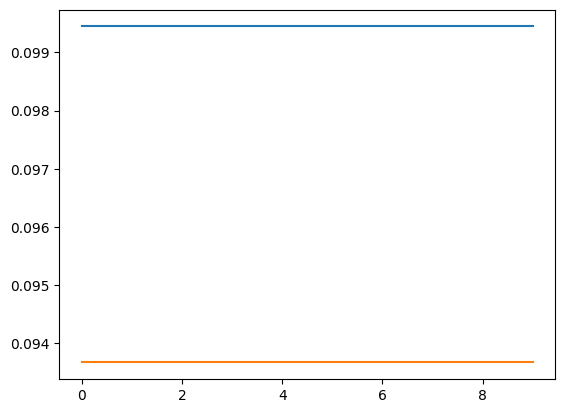

In [ ]:
# Компиляция модели
model.compile(optimizer=AdamW(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор Adadelta - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 36ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 3s 31ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 4s 34ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

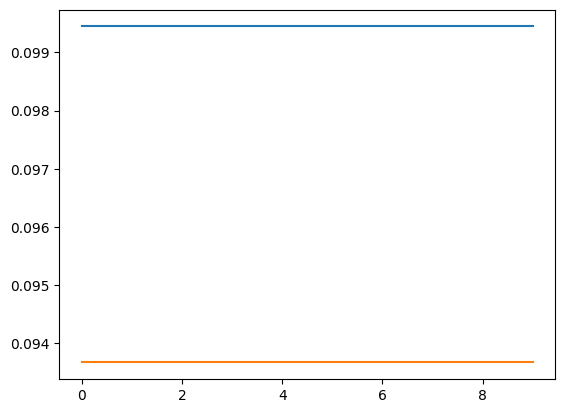

In [ ]:
# Компиляция модели
model.compile(optimizer=Adadelta(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор Adagrad - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 26ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 3s 25ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 3s 25ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 27ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 3s 25ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

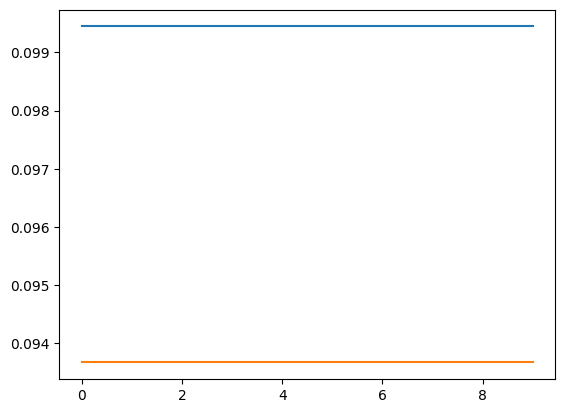

In [ ]:
# Компиляция модели
model.compile(optimizer=Adagrad(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор Adamax - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 28ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 4s 33ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 3s 28ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 28ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 3s 31ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

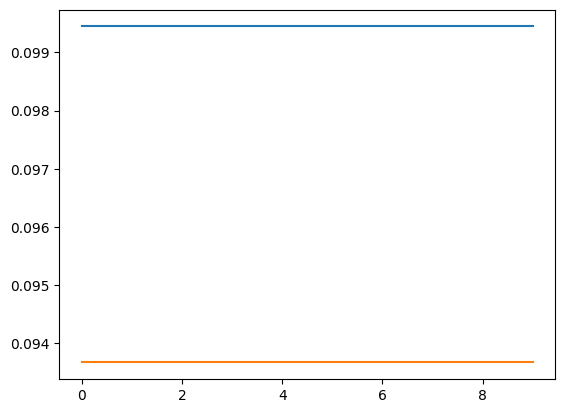

In [ ]:
# Компиляция модели
model.compile(optimizer=Adamax(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор Adafactor - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 35ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 3s 30ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 31ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 3s 28ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

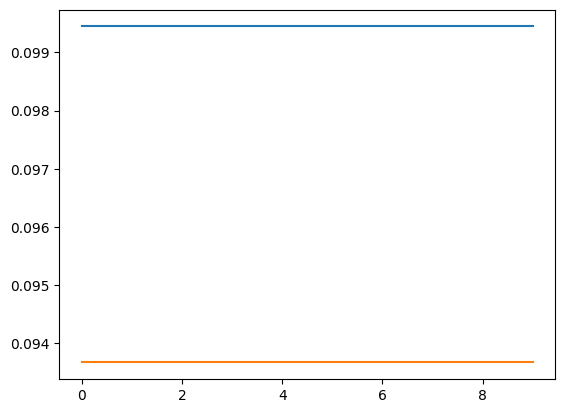

In [ ]:
# Компиляция модели
model.compile(optimizer=Adafactor(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор Nadam - непригоден**

Epoch 1/10
111/111 [==============================] - 62s 35ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 3s 31ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 4s 34ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 4s 32ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [====================

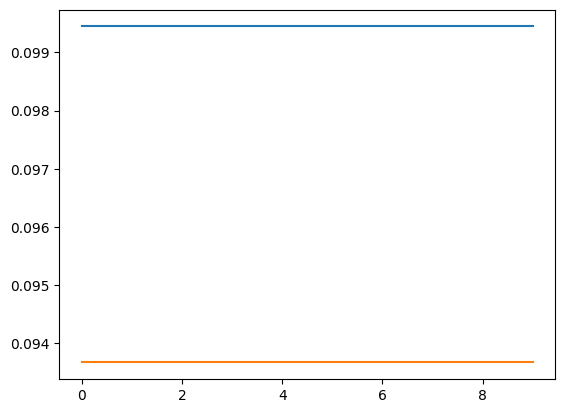

In [ ]:
# Компиляция модели
model.compile(optimizer=Nadam(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Оптимизатор Ftrl - непригоден**

Epoch 1/10
111/111 [==============================] - 4s 36ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 2/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 3/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 4/10
111/111 [==============================] - 4s 34ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 5/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 6/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 7/10
111/111 [==============================] - 3s 29ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0937
Epoch 8/10
111/111 [=====================

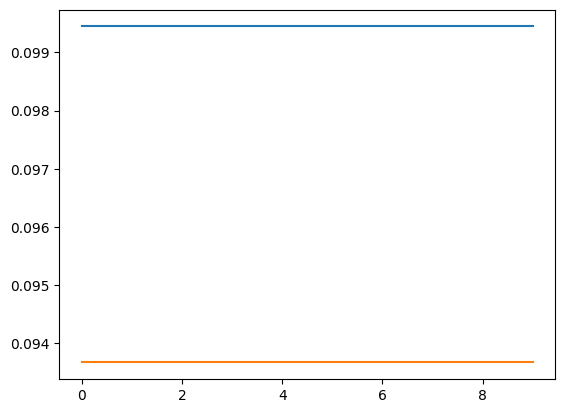

In [ ]:
# Компиляция модели
model.compile(optimizer=Ftrl(learning_rate=0.001),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

# Обучение модели
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,
                                     y_val),
                    epochs = 10,
                    batch_size = 128)

# Вывод графика обучения (точность)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()